# Dimensionality reduction

fMRI data often has a dimensionality problem: we get approximately 100,000 voxels (i.e., features) per volume, but only 100s of time points or trials (i.e., examples). This makes it very hard for machine learning algorithms to model how each voxel contributes. For more on the curse of dimensionality, see here: https://medium.freecodecamp.org/the-curse-of-dimensionality-how-we-can-save-big-data-from-itself-d9fa0f872335

## Goal of this script
>Learn to compute the covariance of a dataset.  
>Reduce the feature space using principal component analysis (PCA).  
>Reduce the feature space using feature selection techniques.  
>Run classification on the dimensionality reduced feature space.  


In [2]:
# Import libraries
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask
import scipy.io
from scipy import stats
from time import time
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, VarianceThreshold, RFECV, chi2, SelectPercentile

Let's set up some functions that we will be using in this script. 

**Exercise 1:** There is an error in load_data. Find it, report it below, and correct it.

**A:** The intersectional mask should be computed as *= and not +=, so as to keep all voxels that are "1" for all runs, and discard voxels that are "0" on even a single run.

In [3]:
# Make a function to load the mask data
def load_data(directory, subject_name, mask_name='', num_runs=3,zscore_data=False):
    
    maskdir = (directory + subject_name + "/preprocessed/masks/")

    # Cycle through the masks
    print ("Processing Start ...")
    
    # If there is a mask supplied then load it now
    if mask_name is not '':
        maskfile = (maskdir + "%s_ventral_%s_locColl_to_epi1.nii.gz" % (subject_name, mask_name))

        mask = nib.load(maskfile)
        print ("Loaded %s mask" % (mask_name))

    # Cycle through the runs
    for run in range(1, num_runs + 1):
        epi_in = (directory + subject_name + "/preprocessed/loc/%s_filtered2_d1_firstExampleFunc_r%d.nii" % (subject_name, run))
        print(epi_in)

        # Load in the fmri data
        epi_data = nib.load(epi_in)
        
        # Mask the data if necessary
        if mask_name is not '':
            nifti_masker = NiftiMasker(mask_img=mask)
            epi_mask_data = nifti_masker.fit_transform(epi_data);
            epi_mask_data = np.transpose(epi_mask_data)
        else:
            # Do a whole brain mask 
            if run == 1:
                mask = compute_epi_mask(epi_data).get_data() # Compute mask from epi
            else:
                mask *= compute_epi_mask(epi_data).get_data() # Get the intersection mask (so that the voxels are the same across runs)   
            
            # Reshape all of the data (not great for memory
            epi_mask_data = epi_data.get_data().reshape(mask.shape[0] * mask.shape[1] * mask.shape[2], epi_data.shape[3])

        # Transpose and Z-score (Standardize) the data  
        if zscore_data == True:
            scaler = preprocessing.StandardScaler().fit(epi_mask_data)
            preprocessed_data =  scaler.transform(epi_mask_data)
        else:
            preprocessed_data = epi_mask_data
        
        # Concatenate the data
        if run == 1:
            concatenated_data = preprocessed_data
        else:
            concatenated_data = np.hstack((concatenated_data, preprocessed_data))
    
    # Now zero out all of the voxels outside of the mask across all runs
    if mask_name is '':
        mask_vector = np.nonzero(mask.reshape(mask.shape[0] * mask.shape[1] * mask.shape[2], ))[0]
        concatenated_data = concatenated_data[mask_vector, :]
        
    # Return the list of mask data
    return concatenated_data

# Make a function for loading in the labels
def load_labels(directory, subject_name):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1,4):
        in_file= (directory + subject_name + '/ses-day2/design_matrix/' + "%s_localizer_0%d.mat" % (subject_name, run))

        # Load in data from matlab
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))

    print("Loaded ", subject_name)
    return stim_label_concatenated


# Convert the TR
def label2TR(num_runs, TR, TRs_run, events_run):
    # Preset the array with zeros
    stim_label_TR = np.zeros((TRs_run * 3, 1))

    # Cycle through the runs
    for run in range(0, num_runs):

        # Cycle through each element in a run
        for i in range(events_run):

            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i

            # What is the time stamp
            time = stim_label_allruns[2, time_idx]

            # What TR does this timepoint refer to?
            TR_idx = int(time / TR) + (run * (TRs_run - 1))

            # Add the condition label to this timepoint
            stim_label_TR[TR_idx]=stim_label_allruns[0, time_idx]
        
    return stim_label_TR

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top.
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line.
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted


# Extract bold data for non-zero labels.
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index] 
    
    return indexed_data, nonzero_labels

# Run a basic n fold classification
def classification(classifier, data, labels, n_folds = 3, test_size=0.1):
    
    # How many folds of the classifier
    skfold = StratifiedShuffleSplit(n_splits=n_folds, test_size=test_size) 

    clf_score = np.array([])
    for train, test in skfold.split(data, labels):

        # Pull out the sample data
        train_data = data[train, :]
        test_data = data[test, :]
        
        # Train and test the classifier
        clf = classifier.fit(train_data, labels[train])
        clf_score = np.hstack((clf_score, clf.score(test_data, labels[test])))

    return clf_score.mean()


The way we analyzed the data in wk3 was problematic because it assumed that each observation was independent. However, note that each trial within a block occurred within 1.5s of each other. In other words, there was substantial overlap in the HRF between adjacent trials. The autocorrelation in fMRI data means that adjacent time points will be similar despite potential variability in the underlying signal.

One way to appropriately deal with this problem of independence is to treat blocks, rather than stimulus events, as our inputs in these analyses.

**Exercise 2:** In the cell below, finish making a function that converts bold_data (the output of reshape_data) and labels into blockwise data, rather than eventwise data.

In [4]:
# Take in a brain volume and label vector that is the length of the event number and convert it into a list the length of the block number
def blockwise_sampling(eventwise_data, eventwise_labels, events_per_block=10):
    
    # How many events are expected
    expected_blocks = int(eventwise_data.shape[0] / events_per_block)
    print(eventwise_data.shape)
    
    # Average the BOLD data for each block of trials into blockwise_data
    blockwise_data = np.zeros((expected_blocks, eventwise_data.shape[1]))
    
    #means = eventwise_data[:,:events_per_block].mean(axis=1)
    for i in range(expected_blocks):
        block_avg = np.mean(eventwise_data[i*events_per_block:i*events_per_block+events_per_block,:], axis=0)
        #print(block_avg.shape)
        blockwise_data[i,:] = block_avg
        #print(blockwise_data.shape)
    print(blockwise_data.shape)
    
    # Downsample labels into blockwise_labels
    print(eventwise_labels.shape)
    blockwise_labels = eventwise_labels[::events_per_block,]
    print(blockwise_labels.shape)
    
    # Report the new variable sizes
    print('Expected blocks: %d; Resampled blocks: %d' % (expected_blocks, blockwise_data.shape[0]))
    
    # Return the variables downsampled_data and downsampled_labels
    return blockwise_data, blockwise_labels

## Covariance 

As a precursor to understanding dimensionality reduction techniques, we need to learn how to compute the covariance matrix because it is often used in these methods.  

We are going to work with whole-brain data this time. You might have memory issues but this is an important problem to grapple with. There are nearly 1 million voxels in every volume we acquire, of which about 15% are in the brain. Despite >100,000 voxels, we only have <1000 time points.

In [5]:
# Preset variables
dir = '/gpfs/milgram/data/cmhn-s18/datasets/vdc/'
num_runs=3
TR=1.5
hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR) # Convert the shift into TRs

sub_id = 1

# Convert the number into a participant folder name
if (sub_id < 10):
    sids = '0' + str(sub_id)
else:
    sids = str(sub_id)   

# Specify the subject name
sub = 'sub-' + sids

# Load subject labels
stim_label_allruns = load_labels(dir, sub)

# Load the fMRI data
epi_mask_data_all = load_data(dir, sub, mask_name='')

# How many events are there on this run
_, events = stim_label_allruns.shape
events_run = int(events / num_runs)

# This can differ per participant
print(sub, '= TRs: ', epi_mask_data_all.shape[1], '; Voxels: ', epi_mask_data_all.shape[0])
TRs_run = int(epi_mask_data_all.shape[1] / num_runs)

# Convert the timing into TR indexes
stim_label_TR = label2TR(num_runs, TR, TRs_run, events_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Perform the reshaping of the data
bold_data, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_all)

# Down sample the data to be blockwise rather than trialwise
bold_data, labels = blockwise_sampling(bold_data, labels)

Loaded  sub-01
Processing Start ...
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
sub-01 = TRs:  930 ; Voxels:  177314
(450, 177314)
(45, 177314)
(450,)
(45,)
Expected blocks: 45; Resampled blocks: 45


The covariance of two variables is calculated as follows: $$ Cov(X,Y) = \frac{\sum_{1}^{N}(X-\bar{X})(Y-\bar{Y})}{(N-1)}$$
where $\mbox{  }  \bar{X} = mean(X), \mbox{  } \bar{Y} = mean(Y), \mbox{  } N = \mbox{number of samples } $

In fMRI, X and Y could be time-series data for two voxels in the simplest case. We could extend this analysis to creating a covariance matrix for a set of voxels.

**Exercise 3:** 
Compute the covariance

In [6]:
# Enter your code here

# Compute the mean of one column of the bold data X
X = bold_data[:,0]
X_mean = np.mean(X)

# Compute the mean of any other column of the bold data  Y
Y = bold_data[:,1]
Y_mean = np.mean(Y)

# Compute the differences from the mean for X and Y.
X_diff = X - X_mean
Y_diff = Y - Y_mean

# Compute the summed product of the differences.
summed_prod = np.dot(X_diff, Y_diff)

# Compute the covariance
N = X_diff.shape[0]
cov = summed_prod/(N - 1)

# Compare your result to the answer got by using np.cov(X,Y)\
cov == np.cov(X, Y)[0, 1]

# The values are equivalent!

True

The covariance is dependent on the units of the measurement. Its value is thus not easily interpretable or comparable across datasets -- e.g. is there a strong relationship between X and Y if the covariance is 200 as compared to 2 or 2000?

Correlation solves this problem by normalizing the range of the covariance from -1 to +1.

$$ Corr(X,Y) = \frac{Cov(X,Y)}{\sqrt{\frac{\sum_{1}^{N}(X-\bar{X})^2}{(N-1)}}\sqrt{\frac{\sum_{1}^{N}(Y-\bar{Y})^2}{(N-1)}}}$$

**Exercise 4:** Compute the correlation manually and with a pre-specified function 

In [7]:
# Compute the correlation manually
X_diff_2 = np.sum(X_diff**2)
Y_diff_2 = np.sum(Y_diff**2)
denom = np.sqrt(X_diff_2/(N - 1)) * np.sqrt(Y_diff_2/(N - 1))
corr = cov/denom
print(corr)

# Now with a function  
print(np.corrcoef(X, Y)[0, 1])

#The values below are equivalent!

0.859764052087
0.859764052087


**Exercise 5**: np.cov can take a matrix as input and calculates the covariance matrix of all columns. Extend the **covariance** computation to a group of 100 voxels. 

In [8]:
# Insert your code here.

# Subselect 100 voxels from bold_data into a matrix.
M = bold_data[:,0:100]

# Use np.cov() to comput the covariance of this matrix.
np.cov(M)

array([[ 9185561.48407841,  9312400.3586238 ,  9112587.03330502, ...,
         7749404.84656315,  7684197.10656068,  7740769.8715036 ],
       [ 9312400.3586238 ,  9459258.69980759,  9253269.69278597, ...,
         7852033.96441195,  7780141.5322633 ,  7841524.79301566],
       [ 9112587.03330502,  9253269.69278597,  9106929.74111014, ...,
         7798228.91275623,  7720130.27250708,  7784579.8437243 ],
       ..., 
       [ 7749404.84656315,  7852033.96441195,  7798228.91275623, ...,
         7856814.62390558,  7788977.0324679 ,  7826946.76200813],
       [ 7684197.10656068,  7780141.5322633 ,  7720130.27250708, ...,
         7788977.0324679 ,  7748525.99647919,  7772549.47630947],
       [ 7740769.8715036 ,  7841524.79301566,  7784579.8437243 , ...,
         7826946.76200813,  7772549.47630947,  7807643.23339952]])

**Bonus:**  What is the maximum number of columns/voxels in the present dataset from which you could calculate the covariance matrix without exceeding available memory (currently 12GB)? Solve this analytically rather than by trial and error.

The covariance matrix has n^2 entries, if n is the number of voxels. 12 GB = 12,000,000,000 bytes. Each entry is a 64-bit float in Numpy, or 8 bytes. Therefore, the total number of entries it can contain is 12 GB/8 B = 1,500,000,000. The square root of this number is 38,729.8. Therefore, the maximum number of possible voxels is 38,729.


## PCA

We will use PCA to reduce the dimensionality of the data. Some voxels may contain correlated information or no information and so the original voxel-dimensional data can be projected into a lower-dimensional "component" space without losing much information.

![image](https://cdn-images-1.medium.com/max/1200/1*Iri_LDMXuz2Qac-8KPeESA.png)

In [9]:
# We now use the PCA function in scikit-learn to reduce the dimensionality of the data
# The number of components was chosen arbitrarily and is likely too high
pca = PCA(n_components=20)
bold_pca = pca.fit_transform(bold_data)

print(bold_pca.shape)

(45, 20)


Let's visualize the variance in the data along different component dimensions. Dimension 1 must display the largest variation.

<IPython.core.display.Javascript object>


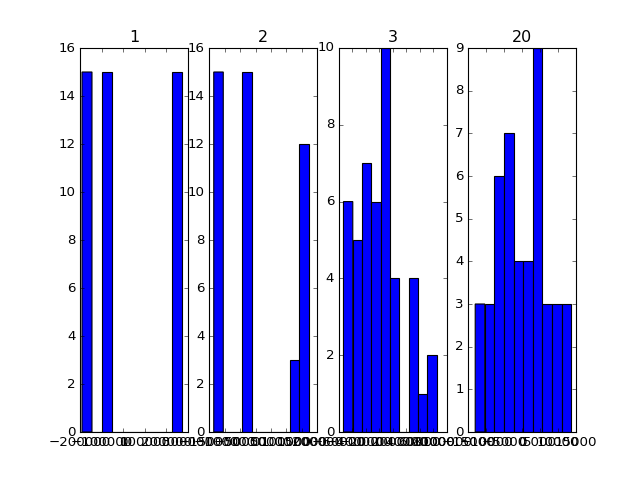

(array([ 3.,  3.,  6.,  7.,  4.,  4.,  9.,  3.,  3.,  3.]),
 array([-13044.05859825, -10375.48877318,  -7706.9189481 ,  -5038.34912303,
         -2369.77929796,    298.79052712,   2967.36035219,   5635.93017727,
          8304.50000234,  10973.06982741,  13641.63965249]),
 <a list of 10 Patch objects>)

In [10]:
plt.figure()
plt.title('Components')
plt.subplot(1, 4, 1)
plt.title('1');
plt.hist(bold_pca[:,0])
plt.subplot(1, 4, 2)
plt.title('2'); 
plt.hist(bold_pca[:,1])
plt.subplot(1, 4, 3)
plt.title('3'); 
plt.hist(bold_pca[:,2])
plt.subplot(1, 4, 4)
plt.title('20'); 
plt.hist(bold_pca[:,19])

Let's visualize the relationship between variances across pairs of components.

<IPython.core.display.Javascript object>


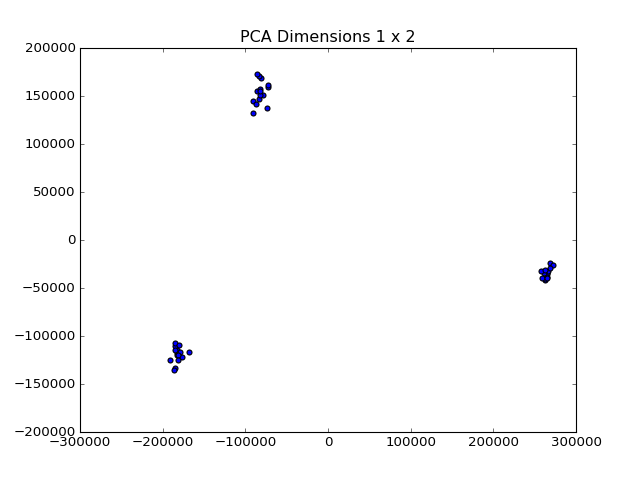

<IPython.core.display.Javascript object>


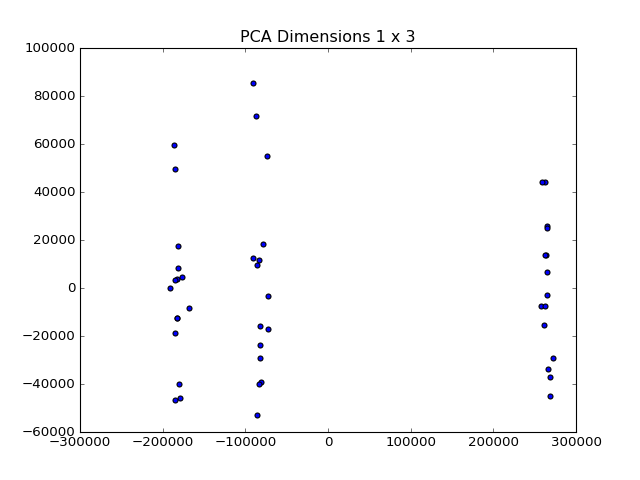

<IPython.core.display.Javascript object>


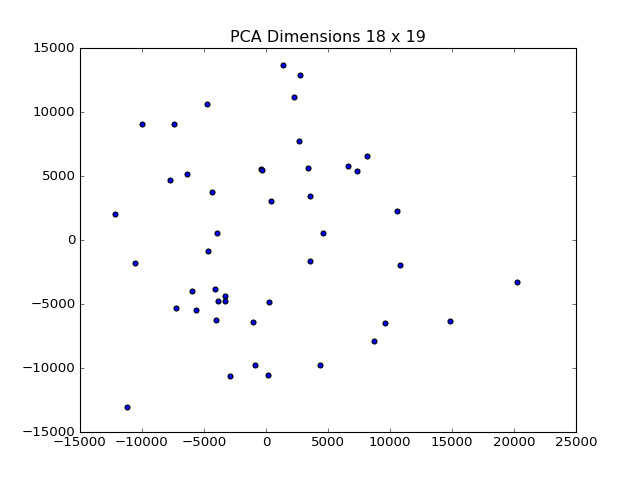

In [11]:
plt.figure()
plt.title('PCA Dimensions 1 x 2')
plt.scatter(bold_pca[:,0], bold_pca[:,1])

plt.figure()
plt.title('PCA Dimensions 1 x 3')
plt.scatter(bold_pca[:,0],bold_pca[:,2])

plt.figure()
plt.title('PCA Dimensions 18 x 19')
plt.scatter(bold_pca[:,18],bold_pca[:,19])

**Self-study:** Look up how to display the amount of variance in the original data explained by each component, called a "scree" plot.

**Exercise 6:** Make a scree plot based on the components above. How many components would be sufficient to account for most of the variance?

Based on the scree plot below, it looks as if 2 components should be sufficient to account for the vast majority of the variance.

<IPython.core.display.Javascript object>


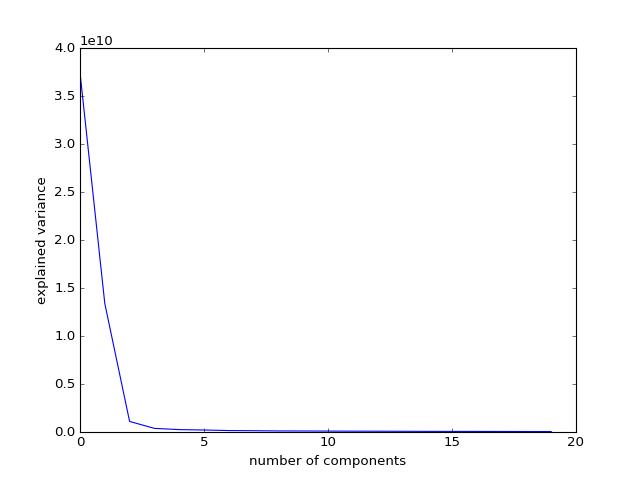

In [12]:
plt.figure()
plt.plot(pca.explained_variance_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

Compare whole-brain classification accuracy without and with PCA dimensionality reduction.

The accuracy goes from 0.67 without PCA to 0.93 when PCA is included! This is a significant increase, especially considering we are now dealing with lower-dimensional data which technically contains less information than the original data set

In [13]:
# Get the baseline, whole brain decoding accuracy. This may take >5 minutes
print('Original size: ', bold_data.shape)
classifier = SVC(kernel="linear", C=0.0001)

start = time()
score_all = classification(classifier, bold_data, labels)
end = time()
print('Accuracy: %0.2f; Run time: %0.2fs' %(score_all, end - start))

Original size:  (45, 177314)
Accuracy: 0.67; Run time: 1.48s


In [14]:
# Run the classifier on the PCA data with different numbers of components included.
classifier_PCA = SVC(kernel="linear", C=0.0001)
start = time()
score_pca = classification(classifier_PCA, bold_pca, labels)
end = time()
print('Accuracy: %0.2f; Run time: %0.2fs' %(score_pca, end - start))

Accuracy: 0.93; Run time: 0.00s


**Exercise 7:** How does accuracy change when we change the number of components?

Accuracy changes nonlinearly with number of components. See plot below. It was changing on every run through the loop -- sometimes, it would max out around 20 or 30, other times it would continue to monotonically increase, and other times it would plateau around 30.

Accuracy: 0.13; Run time: 0.35s; Num Components:  2
Accuracy: 0.33; Run time: 10.64s; Num Components:  5
Accuracy: 0.53; Run time: 0.03s; Num Components: 10
Accuracy: 0.60; Run time: 0.00s; Num Components: 20
Accuracy: 1.00; Run time: 0.00s; Num Components: 30
Accuracy: 1.00; Run time: 0.00s; Num Components: 44


<IPython.core.display.Javascript object>


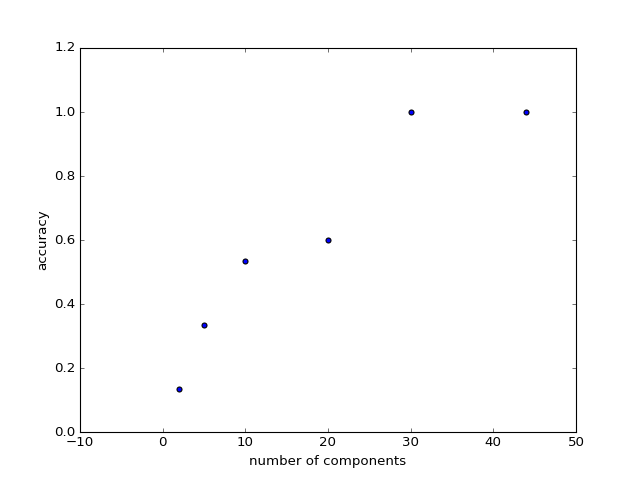

In [15]:
comps = [2, 5, 10, 20, 30, 44]
perf = []
for comp in comps:
    pca = PCA(n_components=comp)
    bold_pca = pca.fit_transform(bold_data)
    start = time()
    score_pca = classification(classifier_PCA, bold_pca, labels)
    end = time()
    perf.append(score_pca)
    print('Accuracy: %0.2f; Run time: %0.2fs; Num Components: %2.0f' %(score_pca, end - start, comp))

plt.figure()
plt.scatter(comps, perf)
plt.xlabel('number of components')
plt.ylabel('accuracy')
plt.show()

You have used dimensionality reduction techniques to speed up and possibly improve classification. The choice of parameters for the classifiers has been arbitary and the number of dimensions for PCA was based on your observation. Below we'll create pipeline to optimize these parameters.

## Feature Selection: ROI

In previous classes you have been doing voxel selection, even if you didn't know. Using the FFA, PPA, or any other mask is an example of voxel selection that can greatly improve your decoding accuracy if you have reason to believe that discriminative information is contained in the ROI.

In [16]:
# Run the classifier on the FFA masked data with
epi_mask_data_FFA = load_data(dir, sub, mask_name='FFA')
bold_FFA, labels = reshape_data(stim_label_TR_shifted, epi_mask_data_FFA)
bold_FFA, labels = blockwise_sampling(bold_FFA, labels)

start = time()
score_FFA = classification(classifier, bold_FFA, labels)
end = time()
print('Accuracy: %0.2f; Run time: %0.2fs' %(score_FFA, end - start))

Processing Start ...
Loaded FFA mask
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
/gpfs/milgram/data/cmhn-s18/datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
(450, 5519)
(45, 5519)
(450,)
(45,)
Expected blocks: 45; Resampled blocks: 45
Accuracy: 0.93; Run time: 0.04s


## Feature Selection: Top n Values

We have as many features as we have voxels. We can reduce the feature space using metrics of our choice and picking the top n voxels that satisfy a metric. Below, we first standardize the data and take the top n voxels that had the highest standard deviation.

In [17]:
# Get the indices, sorted on the measure (in this case: standard deviation) for each voxel.
mean_threshold = np.percentile(np.mean(bold_data, axis = 0), 95)

# numpy sorts ascending to descending, so we are interested in the last n values.
bold_top_N = bold_data[:, mean_threshold <= np.mean(bold_data, axis = 0) ]

print('Top_N size: ', bold_top_N.shape)

score_top_N = classification(classifier, bold_top_N, labels)

print('Accuracy: %0.2f' %(score_top_N))

Top_N size:  (45, 8866)
Accuracy: 0.67


## Feature Selection: Variance Threshold

There are also functions built into sci-kit learn that we could use. One measure that we can use to select voxels is variance. We use the sklearn VarianceThreshold method. http://scikit-learn.org/stable/modules/feature_selection.html#variance-threshold

In [18]:
# Take the 95th percentile of variance
var_threshold = np.percentile(np.std(bold_data, axis=0) ** 2, 95)

selector = VarianceThreshold(threshold=var_threshold)
bold_VT = selector.fit_transform(bold_data)
print('Top variance size: ', bold_VT.shape)
score_VT = classification(classifier, bold_VT, labels)
print('Accuracy: %0.2f' %(score_VT))

Top variance size:  (45, 8866)
Accuracy: 0.67


## Feature Selection: Univariate

We can also use variety of univariate methods to do feature selection using methods built into scikit-learn. We use  chi-squared values and the SelectKBest method below.

**Self-Study:** Not sure what is being tested here? Go find out!

In [19]:
bold_chi = SelectKBest(chi2, k=100).fit_transform(bold_data, labels)
print('K top features: ', bold_chi.shape)

score_chi = classification(classifier, bold_chi, labels)
print('Accuracy: %0.2f' %(score_chi))

K top features:  (45, 100)
Accuracy: 1.00


**Exercise 8:** Apply a dimensionality reduction procedure other than those above that improves performance. What is its run time?

See below.

In [20]:
#select features using sklearn's built-in function
start = time()
f_class = SelectPercentile().fit_transform(bold_data, labels)
end = time()
print('K top features: ', f_class.shape)

f_score = classification(classifier, f_class, labels)
print('Accuracy: %0.2f; Run time: %0.2fs' %(f_score, end - start))

K top features:  (45, 17732)
Accuracy: 1.00; Run time: 0.16s


## Feature Selection: Recursive Feature Elimination (RFE)

This technique eliminates features iteratively based on a measure that we can define, e.g., classification accuracy. At each step of the iteration a certain number of features are eliminated. This is done iteratively until an optimal set of features are found. Importantly, cross-validation is used during each iteration to select the best set of features at each stage. scikit-learn makes this incredibly easy with the method RFECV. Because this is running many iterations of your classifier, you want to be careful not to give it too many features.

In [21]:
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=classifier, 
              step=500, 
              cv=StratifiedShuffleSplit(n_splits=3, test_size=0.1),
              scoring='accuracy')
rfecv.fit(bold_VT, labels)

RFECV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.1,
            train_size=None),
   estimator=SVC(C=0.0001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
   n_jobs=1, scoring='accuracy', step=500, verbose=0)

**Exercise 9**: Report and visualize the results of RFE, including the optimal number of features.

In [22]:
rfe_data = rfecv.transform(bold_VT)
rfe_score = classification(classifier, rfe_data, labels)
print('Accuracy: %0.2f' %(rfe_score))
print('Optimal Number of Features: %4.0f' %(rfecv.n_features_))

Accuracy: 0.87
Optimal Number of Features: 3866


**Novel contribution:** be creative and make one new discovery by adding an analysis, visualization, or optimization.

<IPython.core.display.Javascript object>


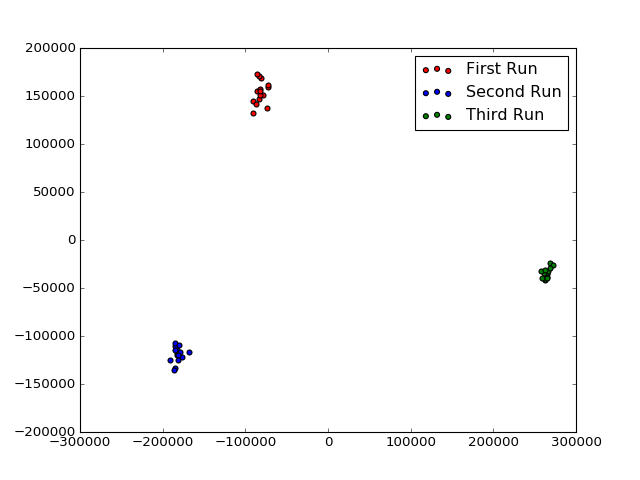

'"\nr1 = mpatches.Patch(color=\'red\', label=\'First Run\')\nr2 = mpatches.Patch(color=\'blue\', label=\'Second Run\')\nr3 = mpatches.Patch(color=\'green\', label=\'Third Run\')\n\nplt.legend(handles=[r1, r2, r3])\nplt.show()\n\ncolormap = [\'red\', \'green\']\nf, ax = plt.subplots(1)\nfor i in np.unique(labels):\n    mask = labels == i\n    plt.scatter(bold_pca[mask, 0], bold_pca[mask, 1], label=i, c=1, cmap=colormap)\nax.legend()\n\n#plt.figure()\nplt.title(\'PCA Dimensions 1 x 2\')\n#plt.scatter(bold_pca[:,0], bold_pca[:,1])\n'

In [36]:
#show that the first and second principal components are pulling out run number, i.e. not useful information for classification

blocks_per_run = 15
f, ax = plt.subplots(1)

plt.scatter(bold_pca[0:blocks_per_run, 0], bold_pca[0:blocks_per_run, 1], c="red")
plt.scatter(bold_pca[blocks_per_run:blocks_per_run*2, 0], bold_pca[blocks_per_run:blocks_per_run*2, 1], c="blue")
plt.scatter(bold_pca[blocks_per_run*2:blocks_per_run*3, 0], bold_pca[blocks_per_run*2:blocks_per_run*3, 1], c="green")

ax.legend(['First Run', 'Second Run', 'Third Run'])